# 线性回归
## 1.线性回归
### (1)基本元素

In [1]:
#介绍基本概念

### (2)矢量化加速

In [2]:
#训练模型时，经常希望可以同时处理整个小批量的样本，为了实现这一点，对计算进行矢量化，利用线性代数库，而不是for循环

%matplotlib inline
import math
import time
import numpy as np
import torch
from d2l import torch as d2l

In [3]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [4]:
#实例化两个全为1的10000维向量，在一种方法中，使用for循环遍历；在另一种方法中，依赖对+的调用

n = 10000
a = torch.ones(n)
b = torch.ones(n)
a

tensor([1., 1., 1.,  ..., 1., 1., 1.])

In [5]:
#我们将频繁进行运行时间的基准测试，需要定义一个计时器

class Timer:    #@save
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()
        
    def start(self):
        """启动计时器"""
        self.tik = time.time()
        
    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]
    
    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)
    
    def sum(self):
        """返回时间总和"""
        return sum(self.times)
    
    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()

In [6]:
#对工作负载进行基准测试
#首先使用for循环，每次执行一位的加法

c = torch.zeros(n)
timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]
f'{timer.stop():.5f} sec'

'0.08577 sec'

In [7]:
#使用重载的+运算符计算按元素的和

timer.start()
d = a + b
f'{timer.stop():.5f} sec'

#明显矢量化代码会带来数量级的加速

'0.00100 sec'

### (3)正态分布与平方损失

In [8]:
#定义正态分布函数

def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)

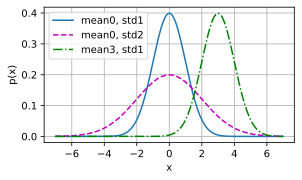

In [9]:
#使用numpy可视化

x = np.arange(-7, 7, 0.01)

#均值和标准差对
params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x', ylabel='p(x)', figsize=(4.5, 2.5)
        , legend = [f'mean{mu}, std{sigma}' for mu, sigma in params])

#改变均值会产生沿x轴的偏移，增加方差将会分散分布、降低其峰值

### (4)从线性回归到深度网络

In [10]:
#介绍基本概念

## 2.线性回归的从零开始实现
### (1)生成数据集

In [2]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l
import os
os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

In [3]:
#根据带噪声的线性模型构造人工数据集
#任务是使用此样本恢复模型参数

def synthetic_data(w, b, num_examples):     #@save
    """生成y=X * w + b + 噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))     #该函数返回从单独的正态分布中提取的随机数的张量，该正态分布的均值为0，方差为1，大小是n个样本，列数是w的长度
    y = torch.matmul(X, w) + b                         #matmul=torch.mm ，进行矩阵乘法    
    y += torch.normal(0, 0.01, y.shape)                #随机噪音=均值为0，方差为0.01且和y形状一样
    return X, y.reshape((-1, 1))                      #把X和y做成列向量返回

true_w = torch.tensor([2, -3.4])                #真实w值
true_b = 4.2                                    #真实b值
features, labels = synthetic_data(true_w, true_b, 1000)

In [4]:
print('features:', features[0], '\nlabel:', labels[0])
print(features.shape)
print(len(features))

features: tensor([0.5009, 0.9283]) 
label: tensor([2.0388])
torch.Size([1000, 2])
1000


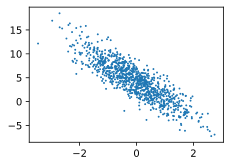

In [5]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(),           #detach分离数值，使其不具有梯度，使用detach返回的tensor和原始的tensor共同一个内存，即一个修改另一个也会跟着改变
                labels.detach().numpy(), 1)

### (2)读取数据集

In [6]:
#定义一个函数，该函数接受批量大小、特征矩阵和标签向量作为输入，生成大小为batch_size的小批量

def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    #这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(indices[i:min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]          #yield类似于return

batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

tensor([[ 0.3630,  1.1871],
        [ 2.2203, -0.7299],
        [ 0.7416, -0.7677],
        [-0.9491, -0.9974],
        [-1.3382, -0.2621],
        [ 0.0786, -1.5023],
        [ 0.2739, -0.2728],
        [-0.0208, -0.4284],
        [-1.0188,  0.1390],
        [-0.5630,  0.4492]]) 
 tensor([[ 0.8809],
        [11.1204],
        [ 8.2833],
        [ 5.6840],
        [ 2.4269],
        [ 9.4646],
        [ 5.6808],
        [ 5.6239],
        [ 1.7189],
        [ 1.5403]])


### (3)初始化模型参数

In [7]:
#定义初始化模型参数

w = torch.normal(0, 0.01, size=(2, 1), requires_grad=True)  
b = torch.zeros(1, requires_grad=True)

#w和b需要更新，所以它们的梯度设置为True

### (4)定义模型

In [8]:
#定义模型

def linreg(X, w, b):
    """线性回归模型"""
    return torch.matmul(X, w) + b

### (5)定义损失函数

In [9]:
#定义损失函数

def squared_loss(y_hat, y):
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape))** 2 / 2

### (6)定义优化算法

In [10]:
#定义优化算法

def sgd(params, lr, batch_size):                  #params指的是包含w和b的列表
    """小批量随机梯度下降"""
    with torch.no_grad():                         #torch.no_grad()该语句包含起来的部分将不会被追踪梯度
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()

### (7)训练

In [11]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)      #X和y的小批量损失
        #因为'l'的形状是('batch_size', 1),而不是一个标量。
        #'l'中的所有元素被加到一起并以此计算关于['w','b']的梯度
        l.sum().backward()
        sgd([w, b], lr, batch_size)      #使用参数的梯度更新梯度
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch{epoch + 1}, loss{float(train_l.mean()):f}')

epoch1, loss0.026416
epoch2, loss0.000090
epoch3, loss0.000049


In [12]:
#比较真实参数和通过训练学到的参数来评估训练的成功程度

print(f'w的估计误差：{true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差：{true_b - b}')

w的估计误差：tensor([0.0003, 0.0001], grad_fn=<SubBackward0>)
b的估计误差：tensor([0.0007], grad_fn=<RsubBackward1>)


## 3.线性回归的简介实现
### (1) 生成数据集

In [1]:
#用深度学习框架简洁实现线性回归模型

import numpy as np
import torch
from torch.utils import data                  #
from d2l import torch as d2l

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

### (2)读取数据集

In [2]:
#调用框架中现有的API来读取数据

def load_array(data_arrays, batch_size, is_train=True):
    """构造一个PyTorch数据迭代器"""
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

next(iter(data_iter))

[tensor([[-1.0968,  0.9431],
         [-0.1297,  1.5952],
         [ 1.2316,  1.0896],
         [-1.9677, -0.0102],
         [-0.5882,  1.1838],
         [ 0.0453,  1.4346],
         [-0.7020,  0.5620],
         [ 0.7793, -0.1142],
         [ 0.4741,  0.1071],
         [ 0.2235,  1.7851]]),
 tensor([[-1.1986],
         [-1.4809],
         [ 2.9630],
         [ 0.2974],
         [-0.9829],
         [-0.5792],
         [ 0.8790],
         [ 6.1534],
         [ 4.7620],
         [-1.4244]])]

### (3)定义模型

In [4]:
#使用框架的预定义好的层
#'nn'是神经网络的缩写

from torch import nn

net = nn.Sequential(nn.Linear(2, 1))   
#Sequential是一个有序的容器，神经网络模块将按照在传入构造器的顺序依次被添加到计算图中执行
#同时以神经网络模块为元素的有序字典也可以作为传入参数

### (4)初始化模型参数

In [5]:
#通过net[0]选择网络中的第一个图层
#normal_是使用正态分布替换掉data的值

net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

### (5)定义损失函数

In [6]:
#计算均方误差使用的是MSELoss类，也称平方L2范数

loss = nn.MSELoss()

### (6)定义优化算法

In [7]:
#实例化SGD

trainer = torch.optim.SGD(net.parameters(), lr=0.03)

### (7)训练

In [8]:
#在每个迭代周期里，我们将完整遍历一次数据集(train_data)，不停地从中获取一个小批量的输入和相应的标签
"""
步骤如下：
1.通过调用net(x)生成预测并计算损失L(前向传播)
2.通过进行反向传播计算梯度
3.通过调用优化器来更新模型参数
"""

num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X), y)
        trainer.zero_grad()
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch{epoch + 1}, loss{l:f}')

epoch1, loss0.000244
epoch2, loss0.000095
epoch3, loss0.000094


In [9]:
w = net[0].weight.data
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print('b的估计误差：', true_b - b)

w的估计误差： tensor([-5.5909e-04, -9.4891e-05])
b的估计误差： tensor([0.0004])
